In [1]:
from astropy.io import fits
from astropy.visualization import simple_norm
from sklearn.model_selection import train_test_split
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import os
import shutil

Moves all the science files and then the cosmic ray masks, then finally the ignore masks.

In [191]:
science_files = glob.glob(os.path.join(os.curdir, "Drizzle Notebooks", "*", "*_flc.fits"))
save_loc = "./data/images/"

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
    
for im in science_files:
    root = im.split('/')[-1]
    shutil.copyfile(im, save_loc + root)

In [192]:
science_files = glob.glob(os.path.join(os.curdir, "Drizzle Notebooks", "*", "*sci1_crmask.fits"))
save_loc = "./data/masks/"

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
    
for im in science_files:
    root = im.split('/')[-1]
    shutil.copyfile(im, save_loc + root)

In [193]:
science_files = glob.glob(os.path.join(os.curdir, "Drizzle Notebooks", "*", "*sci1_single_mask.fits"))
save_loc = "./data/ignore/"

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
    
for im in science_files:
    root = im.split('/')[-1]
    shutil.copyfile(im, save_loc + root)

Plotting a section of one of the images just to test.

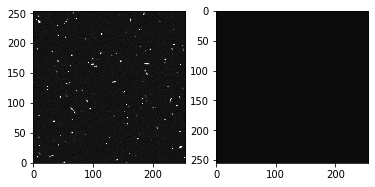

In [2]:
sci = fits.getdata(os.path.join(os.curdir, "data", "images", "jbit11dsq_flc.fits"))
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.arcsinh(sci[0:255, 0:255]), vmin = 0, cmap="gray", origin="lower")
ax[1].imshow(np.arcsinh(np.full_like(sci[0:255, 0:255], np.median(sci))),vmin = 0, vmax = 1000, cmap="gray")

Creates a concatenated stack of all the 256x256 square images.

In [194]:
def get_images(image_names, test=False):
    big = []
    big_mask = []
    big_ignore = []
    
    # Loop over the list of image names and extract all the full names
    for n in image_names:
        image_files = glob.glob(os.path.join(os.curdir, "data", "images", n + "*_flc.fits"))
        for name in image_files:
            d = fits.open(name)
            if d[0].header["EXPTIME"] < 20:
                d.close()
                continue
            d.close()
            
            name = name.split("/")[-1].split("flc")[0]
            
            # Loads the image, then loads the corresponding CR mask.
            working = fits.getdata(os.path.join(os.curdir, "data", "images", name + "flc.fits"), ignore_missing_end=True)
            working_mask = fits.getdata(os.path.join(os.curdir, "data", "masks", name + "sci1_crmask.fits")) == 0
            working_ignore = fits.getdata(os.path.join(os.curdir, "data", "ignore", name + "sci1_single_mask.fits")) == 0
            
            k = np.ones((7,7))
            sat = working > 70000
            sat = ndimage.binary_dilation(sat, k)
            working_ignore = sat.astype(bool) + working_ignore
            
            # Image processing?
#             working = working / 100
                                              
            # Loops over the image and slices it up into 256x256 squares.
            for i in range(128, working.shape[0] - 128, 256):
                for j in range(128, working.shape[1] - 128, 256):
                    big.append(working[i:i+256, j:j+256].reshape(1, 256, 256))
                    big_mask.append(working_mask[i:i+256, j:j+256].reshape(1, 256, 256))

                    temp_ignore = working_ignore[i:i+256, j:j+256].reshape(1, 256, 256)
                    big_ignore.append(temp_ignore)

            for i in range(256, working.shape[0] - 255, 256):
                for j in range(256, working.shape[1] - 255, 256):
                    big.append(working[i:i+256, j:j+256].reshape(1, 256, 256))
                    big_mask.append(working_mask[i:i+256, j:j+256].reshape(1, 256, 256))

                    temp_ignore = working_ignore[i:i+256, j:j+256].reshape(1, 256, 256)
                    big_ignore.append(temp_ignore)

            #print(len(big))
            
    # Concatenates the images into nice numpy arrays
    big = np.concatenate(big)
    big_mask = np.concatenate(big_mask)
    big_ignore = np.concatenate(big_ignore)
    
    return (big, big_mask, big_ignore)

In [232]:
# Extragalactic field

# Arrays of 3 in order: image, mask, ignore
eg_train = [0,0,0]
eg_train_names = ["j9700", "jbit1"]
eg_train[0], eg_train[1], eg_train[2] = get_images(eg_train_names)

eg_test = [0,0,0]
eg_test_names = ["jcoz44"]
eg_test[0], eg_test[1], eg_test[2] = get_images(eg_test_names, True)

# Globular cluster
gc_train = [0,0,0]
gc_train_names = ["j9l907", "j9l908"]
gc_train[0], gc_train[1], gc_train[2] = get_images(gc_train_names)

gc_test = [0,0,0]
gc_test_names = ["j9l906"]#, "j9l909"]
gc_test[0], gc_test[1], gc_test[2] = get_images(gc_test_names, True)

# Resolved galaxy
res_train = [0,0,0]
res_train_names = ["j8z00", "j9el3"]
res_train[0], res_train[1], res_train[2] = get_images(res_train_names)

res_test = [0,0,0]
res_test_names = ["j90o"]
res_test[0], res_test[1], res_test[2] = get_images(res_test_names, True)

# Joins all the training data 
print(len(eg_test[0]))
print(len(gc_test[0]))
print(len(res_test[0]))
im_train = np.copy(gc_train[0])#np.concatenate([eg_train[0], gc_train[0], res_train[0]])
mask_train = np.copy(gc_train[1])#np.concatenate([eg_train[1], gc_train[1], res_train[1]])
ignore_train = np.copy(gc_train[2])#np.concatenate([eg_train[2], gc_train[2], res_train[2]])

# Sky background levels the quick and dirty way.
sky_train = np.asarray([np.median(i) for i in im_train])

print(im_train.shape)
print(mask_train.shape)
print(ignore_train.shape)
print(sky_train.shape)

630
840
840
(1890, 256, 256)
(1890, 256, 256)
(1890, 256, 256)
(1890,)


In [5]:
from deepCR import deepCR
from deepCR import train
from deepCR import roc

Begin first 24 epochs of training
Use batch statistics for batch normalization; keep running statistics to be used in phase1

----------- epoch = 1 -----------
[TPR=0.489, FPR=0.003] @threshold = 0.5
loss = 0.0297

----------- epoch = 2 -----------
[TPR=0.450, FPR=0.001] @threshold = 0.5
loss = 0.0181

----------- epoch = 3 -----------
[TPR=0.494, FPR=0.000] @threshold = 0.5
loss = 0.0124

----------- epoch = 4 -----------
[TPR=0.730, FPR=0.001] @threshold = 0.5
loss = 0.0085

----------- epoch = 5 -----------
[TPR=0.725, FPR=0.000] @threshold = 0.5
loss = 0.0074

----------- epoch = 6 -----------
[TPR=0.799, FPR=0.001] @threshold = 0.5
loss = 0.0069

----------- epoch = 7 -----------
[TPR=0.831, FPR=0.001] @threshold = 0.5
loss = 0.0060

----------- epoch = 8 -----------
[TPR=0.834, FPR=0.001] @threshold = 0.5
loss = 0.0057

----------- epoch = 9 -----------
[TPR=0.842, FPR=0.001] @threshold = 0.5
loss = 0.0058



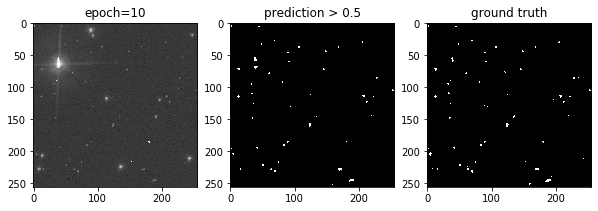

----------- epoch = 10 -----------
[TPR=0.823, FPR=0.001] @threshold = 0.5
loss = 0.0055

----------- epoch = 11 -----------
[TPR=0.818, FPR=0.000] @threshold = 0.5
loss = 0.0054

----------- epoch = 12 -----------
[TPR=0.823, FPR=0.000] @threshold = 0.5
loss = 0.0051

----------- epoch = 13 -----------
[TPR=0.817, FPR=0.000] @threshold = 0.5
loss = 0.0052

----------- epoch = 14 -----------
[TPR=0.821, FPR=0.000] @threshold = 0.5
loss = 0.0051

----------- epoch = 15 -----------
[TPR=0.826, FPR=0.000] @threshold = 0.5
loss = 0.0051

----------- epoch = 16 -----------
[TPR=0.872, FPR=0.001] @threshold = 0.5
loss = 0.0050

----------- epoch = 17 -----------
[TPR=0.850, FPR=0.001] @threshold = 0.5
loss = 0.0048

----------- epoch = 18 -----------
[TPR=0.863, FPR=0.001] @threshold = 0.5
loss = 0.0049

----------- epoch = 19 -----------
[TPR=0.883, FPR=0.001] @threshold = 0.5
loss = 0.0049



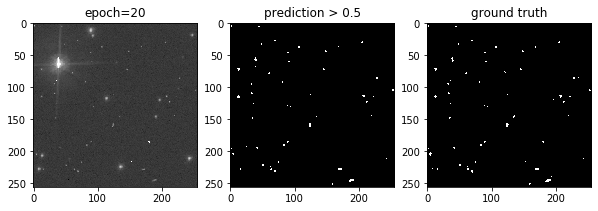

----------- epoch = 20 -----------
[TPR=0.879, FPR=0.001] @threshold = 0.5
loss = 0.0047

----------- epoch = 21 -----------
[TPR=0.872, FPR=0.001] @threshold = 0.5
loss = 0.0047

----------- epoch = 22 -----------
[TPR=0.882, FPR=0.001] @threshold = 0.5
loss = 0.0047
Saved to 2019-12-04_manta_gc_epoch22.pth

----------- epoch = 23 -----------
[TPR=0.877, FPR=0.001] @threshold = 0.5
loss = 0.0046
Saved to 2019-12-04_manta_gc_epoch23.pth

----------- epoch = 24 -----------
[TPR=0.877, FPR=0.001] @threshold = 0.5
loss = 0.0045
Saved to 2019-12-04_manta_gc_epoch24.pth

Continue onto next 36 epochs of training
Batch normalization running statistics frozen and used

----------- epoch = 25 -----------
[TPR=0.860, FPR=0.001] @threshold = 0.5
loss = 0.0053

----------- epoch = 26 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0049

----------- epoch = 27 -----------
[TPR=0.892, FPR=0.001] @threshold = 0.5
loss = 0.0041
Saved to 2019-12-04_manta_gc_epoch27.pth

----------- epoch =

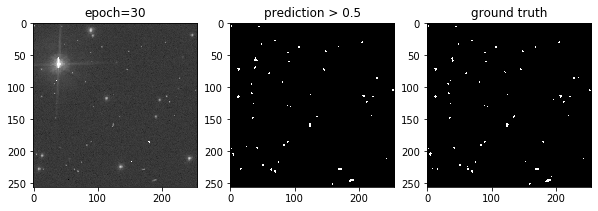

----------- epoch = 30 -----------
[TPR=0.899, FPR=0.001] @threshold = 0.5
loss = 0.0037
Saved to 2019-12-04_manta_gc_epoch30.pth

----------- epoch = 31 -----------
[TPR=0.899, FPR=0.001] @threshold = 0.5
loss = 0.0036
Saved to 2019-12-04_manta_gc_epoch31.pth

----------- epoch = 32 -----------
[TPR=0.902, FPR=0.001] @threshold = 0.5
loss = 0.0036
Saved to 2019-12-04_manta_gc_epoch32.pth

----------- epoch = 33 -----------
[TPR=0.902, FPR=0.001] @threshold = 0.5
loss = 0.0036
Saved to 2019-12-04_manta_gc_epoch33.pth

----------- epoch = 34 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0035
Saved to 2019-12-04_manta_gc_epoch34.pth

----------- epoch = 35 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0035
Saved to 2019-12-04_manta_gc_epoch35.pth

----------- epoch = 36 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0035
Saved to 2019-12-04_manta_gc_epoch36.pth

----------- epoch = 37 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0

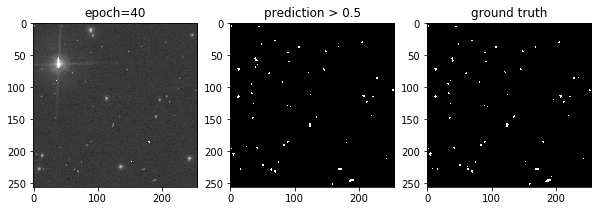

----------- epoch = 40 -----------
[TPR=0.902, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 41 -----------
[TPR=0.903, FPR=0.001] @threshold = 0.5
loss = 0.0034
Saved to 2019-12-04_manta_gc_epoch41.pth

----------- epoch = 42 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 43 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 44 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0034
Epoch    43: reducing learning rate of group 0 to 5.0000e-04.

----------- epoch = 45 -----------
[TPR=0.900, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 46 -----------
[TPR=0.899, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 47 -----------
[TPR=0.899, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 48 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 49 -----------
[TPR=0.900, FPR=0.001] @threshold = 0.5
loss = 0.003

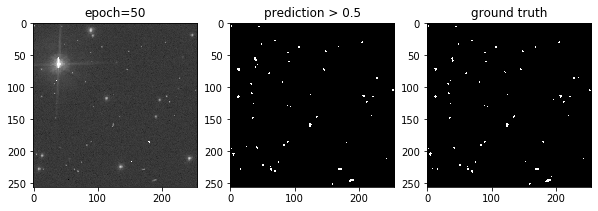

----------- epoch = 50 -----------
[TPR=0.901, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 51 -----------
[TPR=0.903, FPR=0.001] @threshold = 0.5
loss = 0.0034
Epoch    50: reducing learning rate of group 0 to 5.0000e-05.

----------- epoch = 52 -----------
[TPR=0.904, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 53 -----------
[TPR=0.905, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 54 -----------
[TPR=0.906, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 55 -----------
[TPR=0.907, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 56 -----------
[TPR=0.907, FPR=0.001] @threshold = 0.5
loss = 0.0034

----------- epoch = 57 -----------
[TPR=0.907, FPR=0.001] @threshold = 0.5
loss = 0.0035

----------- epoch = 58 -----------
[TPR=0.907, FPR=0.001] @threshold = 0.5
loss = 0.0035
Epoch    57: reducing learning rate of group 0 to 5.0000e-06.

----------- epoch = 59 -----------
[TPR=0.907, FPR=0.001] @thresho

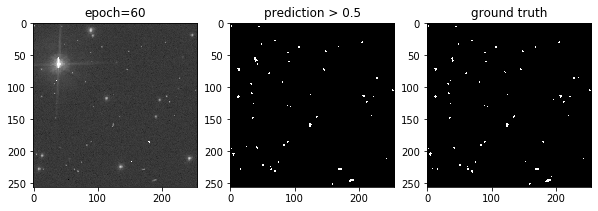

----------- epoch = 60 -----------
[TPR=0.907, FPR=0.001] @threshold = 0.5
loss = 0.0035



In [114]:
trainer = train(im_train, mask_train, ignore=ignore_train, name="manta_gc", sky=sky_train, aug_sky=[-0.9, 3],
                epoch=60, save_after=20, plot_every=10, use_tqdm=False)
trainer.train()
filename = trainer.save()

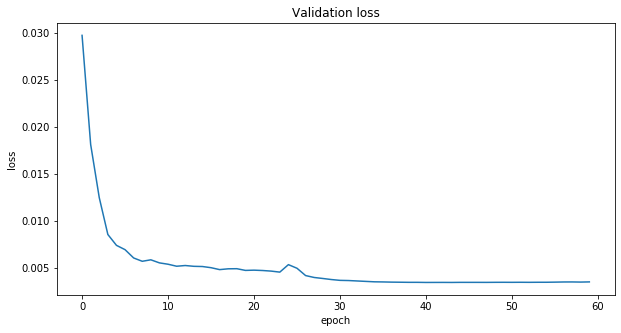

In [115]:
trainer.plot_loss()
#filename = trainer.save()

In [207]:
mdl = deepCR(mask='2019-12-03_manta_8_epoch60.pth', hidden=32, device="GPU")

eg_sky = []
for patch in eg_test:
    eg_sky.append(np.median(patch))
    
gc_sky = []
for patch in gc_test:
    gc_sky.append(np.median(patch))
    
res_sky = []
for patch in res_test:
    res_sky.append(np.median(patch))

# (eg_tpr, eg_fpr), (eg_tpr_d, eg_fpr_d) = roc(mdl, eg_test[0], eg_test[1], eg_test[2], eg_sky, dilate=True, rad=1)
(gc_tpr, gc_fpr), (gc_tpr_d, gc_fpr_d) = roc(mdl, gc_test[0], gc_test[1], gc_test[2], gc_sky, dilate=True, rad=1)
# (res_tpr, res_fpr), (res_tpr_d, res_fpr_d) = roc(mdl, res_test[0], res_test[1], res_test[2], res_sky, dilate=True, rad=1)

100%|██████████| 2100/2100 [36:55<00:00,  1.06s/it]


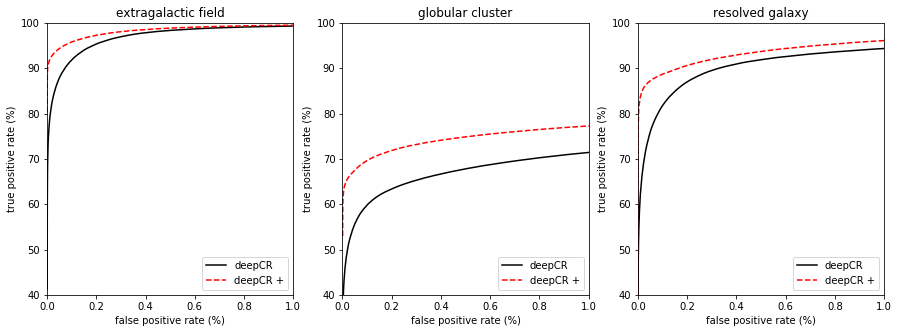

In [208]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

# Extragalactic field
x_max = 1
ax[0].plot(eg_fpr, eg_tpr, "k", label="deepCR")
ax[0].plot(eg_fpr, eg_tpr_d, "r--", label="deepCR +")
ax[0].set_xlim(0, x_max)
ax[0].set_ylim(40, 100)
ax[0].set_title("extragalactic field")
ax[0].set_xlabel("false positive rate (%)")
ax[0].set_ylabel("true positive rate (%)")
ax[0].legend(loc=4)

# Globular cluster
ax[1].plot(gc_fpr, gc_tpr, "k", label="deepCR")
ax[1].plot(gc_fpr, gc_tpr_d, "r--", label="deepCR +")
ax[1].set_xlim(0, x_max)
ax[1].set_ylim(40, 100)
ax[1].set_title("globular cluster")
ax[1].set_xlabel("false positive rate (%)")
ax[1].set_ylabel("true positive rate (%)")
ax[1].legend(loc=4)

# Resolved galaxy
ax[2].plot(res_fpr, res_tpr, "k", label="deepCR")
ax[2].plot(res_fpr, res_tpr_d, "r--", label="deepCR +")
ax[2].set_xlim(0, x_max)
ax[2].set_ylim(40, 100)
ax[2].set_title("resolved galaxy")
ax[2].set_xlabel("false positive rate (%)")
ax[2].set_ylabel("true positive rate (%)")
ax[2].legend(loc=4)

plt.show()

In [ ]:
# Test all of the data at once.
im_test = np.concatenate([eg_test[0], gc_test[0], res_test[0]])
mask_test = np.concatenate([eg_test[1], gc_test[1], res_test[1]])
ignore_test = np.concatenate([eg_test[2], gc_test[2], res_test[2]])
(tpr, fpr), (tpr_d, fpr_d)  = roc(mdl, image=im_test, mask=mask_test, ignore=ignore_test, dilate=True, rad=2)

Text(0, 0.5, 'true positive rate (%)')

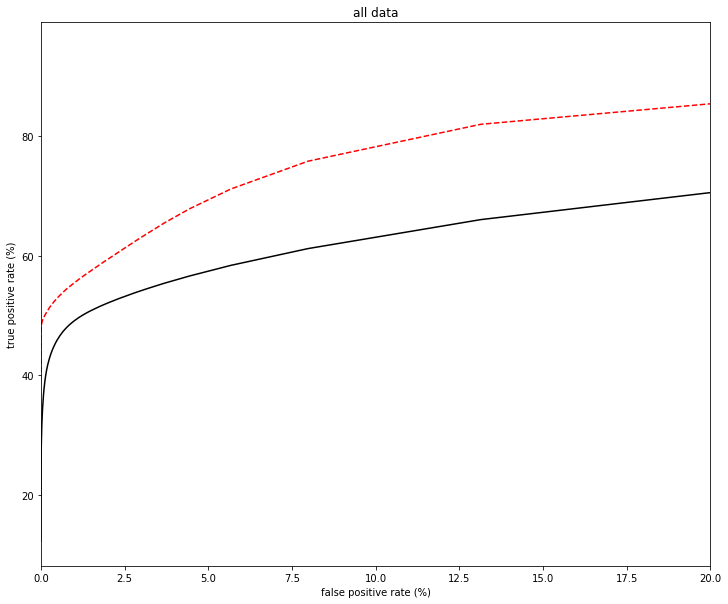

In [123]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)

ax.plot(fpr, tpr, "k", label="deepCR")
ax.plot(fpr, tpr_d, "r--", label="deepCR +")
ax.set_xlim(0,20)
ax.set_title("all data")
ax.set_xlabel("false positive rate (%)")
ax.set_ylabel("true positive rate (%)")

In [6]:
from deepCR import roc_lacosmic

In [167]:
# 4.5 seems to be default sigclip size.
# Objlim = 2, 3.5, 5 from paper.
s1 = np.linspace(3, 30, 30)
s2 = np.linspace(4, 60, 30)
s3 = np.linspace(2 ** (1 / 4), 40 ** (1 / 4), 30) ** 4
(eg_tpr_lc, eg_fpr_lc), (eg_tpr_lc_d, eg_fpr_lc_d) = roc_lacosmic(eg_test[0], eg_test[1], s1, ignore=eg_test[2], objlim=2, dilate=True, rad=2)
(gc_tpr_lc, gc_fpr_lc), (gc_tpr_lc_d, gc_fpr_lc_d) = roc_lacosmic(gc_test[0], gc_test[1], s2, ignore=gc_test[2], objlim=3.5, dilate=True, rad=2)
(res_tpr_lc, res_fpr_lc), (res_tpr_lc_d, res_fpr_lc_d) = roc_lacosmic(res_test[0], res_test[1], s3, ignore=res_test[2], objlim=5, dilate=True, rad=2)

100%|██████████| 840/840 [18:19<00:00,  1.31s/it]


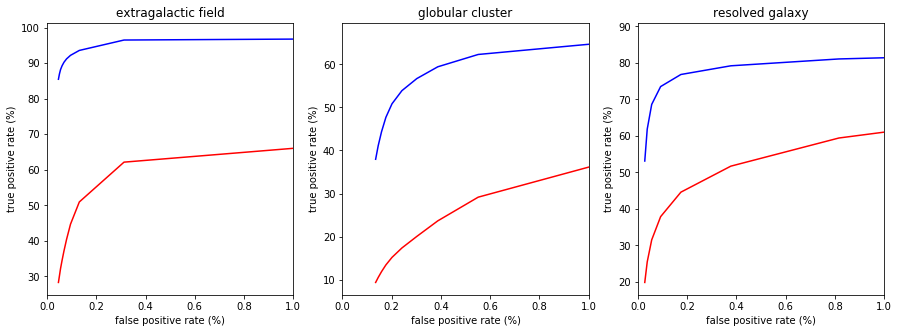

In [12]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

# Extragalactic field
x_max = 1
ax[0].plot(eg_fpr_lc, eg_tpr_lc, c="r")
ax[0].plot(eg_fpr_lc, eg_tpr_lc_d, c="b")
ax[0].set_xlim(0, x_max)
ax[0].set_title("extragalactic field")
ax[0].set_xlabel("false positive rate (%)")
ax[0].set_ylabel("true positive rate (%)")

# Globular cluster
ax[1].plot(gc_fpr_lc, gc_tpr_lc, c="r")
ax[1].plot(gc_fpr_lc, gc_tpr_lc_d, c="b")
ax[1].set_xlim(0, x_max)
ax[1].set_title("globular cluster")
ax[1].set_xlabel("false positive rate (%)")
ax[1].set_ylabel("true positive rate (%)")

# Resolved galaxy
ax[2].plot(res_fpr_lc, res_tpr_lc, c="r")
ax[2].plot(res_fpr_lc, res_tpr_lc_d, c="b")
ax[2].set_xlim(0, x_max)
ax[2].set_title("resolved galaxy")
ax[2].set_xlabel("false positive rate (%)")
ax[2].set_ylabel("true positive rate (%)")

plt.show()

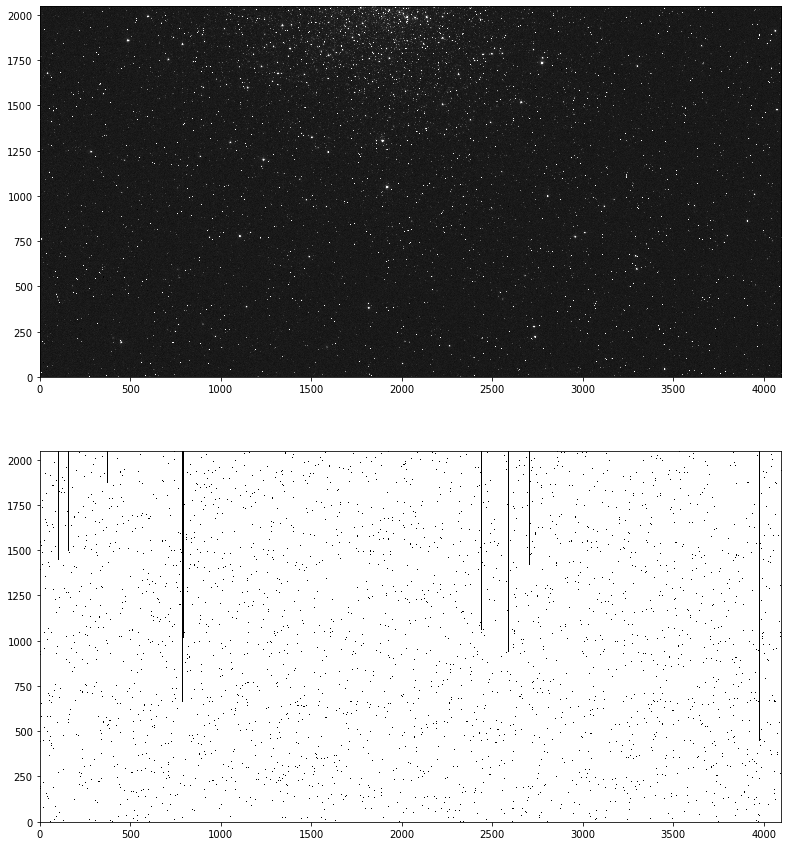

In [10]:
sci1 = fits.getdata(os.path.join(os.curdir, "data", "images", "j9l908fmq_flt.fits"))
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 15)
ax[0].imshow(sci1, vmin=0, vmax=1000, cmap="gray", origin='lower')

sci2 = fits.getdata(os.path.join(os.curdir, "Drizzle Notebooks", "HST-10775-08", "j9l908fmq_sci1_single_mask.fits"))
ax[1].imshow(sci2, cmap="gray", origin='lower')


In [15]:
from deepCR import deepCR

In [ ]:
mdl2 = deepCR(mask="ACS-WFC-F606W-2-32", inpaint="ACS-WFC-F606W-2-32", device="GPU") 

# (eg_tpr2, eg_fpr2), (eg_tpr_d2, eg_fpr_d2) = roc(mdl2, eg_test[0], eg_test[1], eg_test[2], eg_sky, dilate=True, rad=2)
(gc_tpr2, gc_fpr2), (gc_tpr_d2, gc_fpr_d2) = roc(mdl2, gc_test[0], gc_test[1], gc_test[2], gc_sky, dilate=True, rad=2)
# (res_tpr2, res_fpr2), (res_tpr_d2, res_fpr_d2) = roc(mdl, res_test[0], res_test[1], res_test[2], res_sky, dilate=True, rad=2)

 15%|█▌        | 319/2100 [07:09<39:56,  1.35s/it]

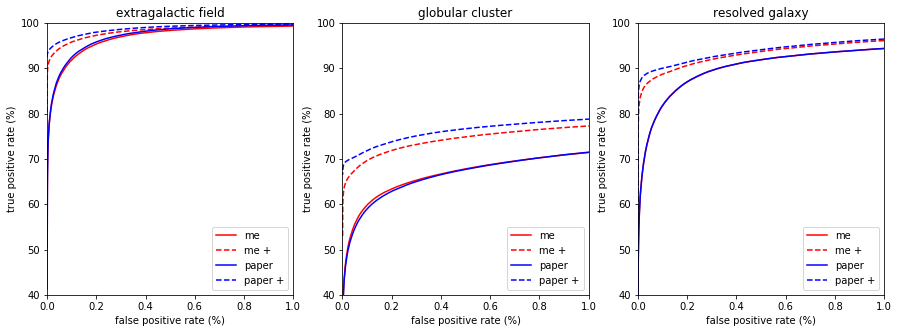

In [211]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

# Extragalactic field
x_max = 1
y_max = 100
ax[0].plot(eg_fpr, eg_tpr, "r", label="me")
ax[0].plot(eg_fpr, eg_tpr_d, "r--", label="me +")
ax[0].plot(eg_fpr2, eg_tpr2, "b", label="paper")
ax[0].plot(eg_fpr2, eg_tpr_d2, "b--", label="paper +")
# ax[0].plot(eg_fpr_lc, eg_tpr_lc, "g", label="lc")
# ax[0].plot(eg_fpr_lc, eg_tpr_lc_d, "g--", label="lc +")
ax[0].set_xlim(0, x_max)
ax[0].set_ylim(40, y_max)
ax[0].set_title("extragalactic field")
ax[0].set_xlabel("false positive rate (%)")
ax[0].set_ylabel("true positive rate (%)")
ax[0].legend(loc=4)

# Globular cluster
ax[1].plot(gc_fpr, gc_tpr, "r", label="me")
ax[1].plot(gc_fpr, gc_tpr_d, "r--", label="me +")
ax[1].plot(gc_fpr2, gc_tpr2, "b", label="paper")
ax[1].plot(gc_fpr2, gc_tpr_d2, "b--", label="paper +")
# ax[1].plot(gc_fpr_lc, gc_tpr_lc, "g", label="lc")
# ax[1].plot(gc_fpr_lc, gc_tpr_lc_d, "g--", label="lc +")
ax[1].set_xlim(0, x_max)
ax[1].set_ylim(40, y_max)
ax[1].set_title("globular cluster")
ax[1].set_xlabel("false positive rate (%)")
ax[1].set_ylabel("true positive rate (%)")
ax[1].legend(loc=4)

# Resolved galaxy
ax[2].plot(res_fpr, res_tpr, "r", label="me")
ax[2].plot(res_fpr, res_tpr_d, "r--", label="me +")
ax[2].plot(res_fpr2, res_tpr2, "b", label="paper")
ax[2].plot(res_fpr2, res_tpr_d2, "b--", label="paper +")
# ax[2].plot(res_fpr_lc, res_tpr_lc, "g", label="lc")
# ax[2].plot(res_fpr_lc, res_tpr_lc_d, "g--", label="lc +")
ax[2].set_xlim(0, x_max)
ax[2].set_ylim(40, y_max)
ax[2].set_title("resolved galaxy")
ax[2].set_xlabel("false positive rate (%)")
ax[2].set_ylabel("true positive rate (%)")
ax[2].legend(loc=4)


plt.savefig("deepCR-test-5.png")
plt.show()

In [176]:
print(np.max(gc_fpr))

0.6243576050748421


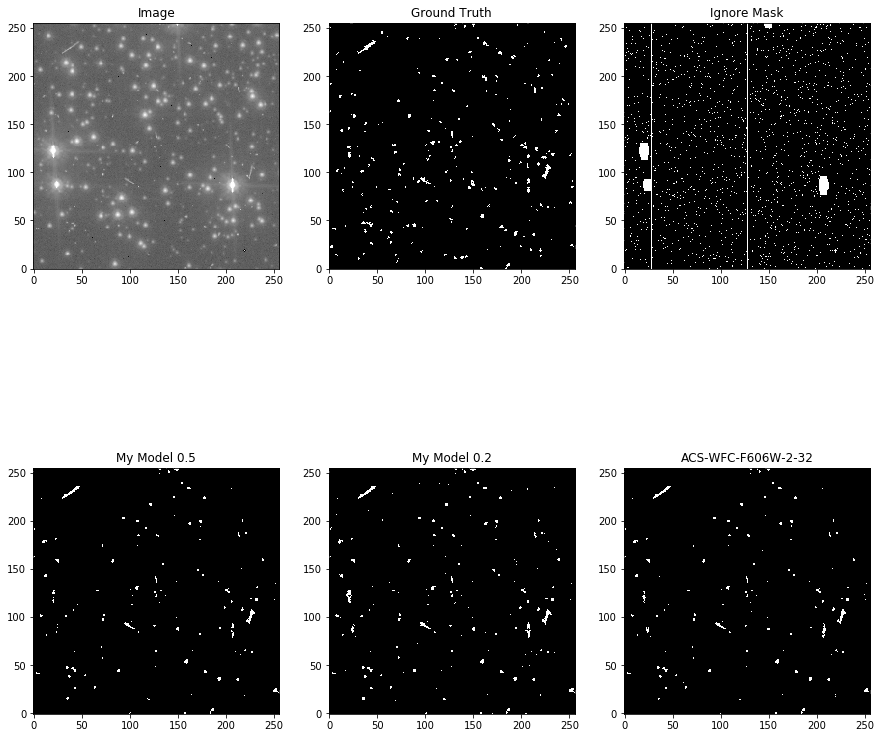

In [130]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 15)
ax[0,0].imshow(np.arcsinh(gc_test[0][50]), vmin=0, cmap="gray", origin='lower')
ax[0,0].set_title("Image")
ax[0,1].imshow(gc_test[1][50], cmap="gray", origin='lower')
ax[0,1].set_title("Ground Truth")
ax[0,2].imshow(gc_test[2][50], cmap="gray", origin='lower')
ax[0,2].set_title("Ignore Mask")

ax[1,0].imshow(np.zeros((256, 256)),cmap="gray")

ax[1,0].imshow(mdl.clean(gc_test[0][50])[0], cmap="gray", origin='lower')
ax[1,0].set_title("My Model 0.5")

ax[1,1].imshow(mdl.clean(gc_test[0][50], threshold=0.2)[0], cmap="gray", origin='lower')
ax[1,1].set_title("My Model 0.2")

ax[1,2].imshow(mdl2.clean(gc_test[0][50])[0], cmap="gray", origin='lower')
ax[1,2].set_title("ACS-WFC-F606W-2-32")

plt.savefig("256px_test.png", bbox_inches="tight")

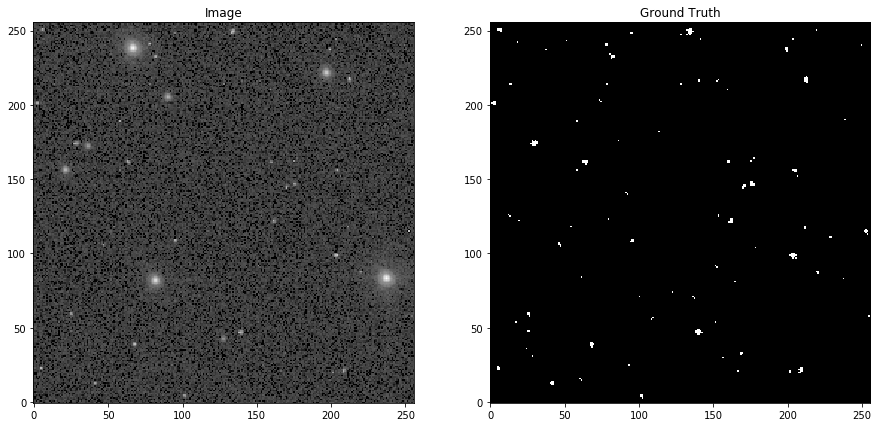

In [239]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
i = int(len(gc_test[0]) / 2) + 40
ax[0].imshow(np.arcsinh(gc_test[0][i]), vmin=0, cmap="gray", origin='lower')
ax[0].set_title("Image")
ax[1].imshow(gc_test[1][i], cmap="gray", origin='lower')
ax[1].set_title("Ground Truth")

plt.savefig("10775_06_slice.png", bbox_inches="tight")

In [182]:
from tqdm import tqdm
tqdm._instances.clear()